In [1]:
import plaidml.keras
plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [2]:
# Importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, Flatten, MaxPooling1D
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras import optimizers

import time 

### Data Processing

In [3]:
df = pd.read_csv('../data/num_data.csv')

In [4]:
dataset = df

In [5]:
dataset.shape

(420768, 16)

In [6]:
# Useful functions
def plot_predictions(test, predicted):
    plt.figure(figsize=(30, 15));
    plt.plot(test, color='red', alpha=0.5, label='Actual PM2.5 Concentration',)
    plt.plot(predicted, color='blue', alpha=0.5, label='Predicted PM2.5 Concentation')
    plt.title('PM2.5 Concentration Prediction')
    plt.xlabel('Time')
    plt.ylabel('PM2.5  Concentration')
    plt.legend()
    plt.show()
    

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    return rmse

In [7]:
data_size = dataset.shape[0]
train_size=int(data_size * 0.6)
test_size = 100
valid_size = data_size - train_size - test_size

test_next_day = [12, 24, 48]

In [8]:
training_set = dataset[:train_size].values
valid_set = dataset[train_size:train_size+valid_size].values
test_set = dataset[data_size-test_size:].values

In [9]:
y = dataset.iloc[:,4].values
y = y.reshape(-1,1)
n_feature = training_set.shape[1]
y.shape

(420768, 1)

In [10]:
# Scaling the dataset
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
valid_set_scaled = sc.fit_transform(valid_set)
test_set_scaled = sc.fit_transform(test_set)

sc_y = MinMaxScaler(feature_range=(0,1))
y_scaled = sc_y.fit_transform(y)

In [11]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X_, y_ = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1:out_end_ix, 0]
        X_.append(seq_x)
        y_.append(seq_y)
    return np.array(X_), np.array(y_)

In [12]:
n_steps_in = 24
n_steps_out = 24
X_train, y_train = split_sequences(training_set_scaled, n_steps_in, n_steps_out)
X_valid, y_valid = split_sequences(valid_set_scaled, n_steps_in, n_steps_out)
X_test, y_test = split_sequences(test_set_scaled, n_steps_in, n_steps_out)

In [13]:
GRU_LSTM_reg = Sequential()
GRU_LSTM_reg.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],n_feature), activation='tanh'))
GRU_LSTM_reg.add(LSTM(units=50, activation='tanh'))
GRU_LSTM_reg.add(Dense(units=n_steps_out))


# Compiling the RNNs
adam = optimizers.Adam(lr=0.01)
GRU_LSTM_reg.compile(optimizer=adam,loss='mean_squared_error')

INFO:plaidml:Opening device "llvm_cpu.0"


In [14]:
RnnModelDict = {'GRU_LSTM': GRU_LSTM_reg}

X_test_24 = X_test[:24]
y_test_24 = y_test[:24]
rmse_df = pd.DataFrame(columns=['Model', 'train_rmse', 'valid_rmse', 'train_time'])

# RnnModelDict = {'LSTM_GRU': LSTM_GRU_reg}

In [15]:
for model in RnnModelDict:
    regressor = RnnModelDict[model]
    
    print('training start for', model)    
    start = time.process_time()
    regressor.fit(X_train,y_train,epochs=50,batch_size=32)
    train_time = round(time.process_time() - start, 2)
    
    print('results for training set')
    y_train_pred = regressor.predict(X_train)
#     plot_predictions(y_train,y_train_pred)
    train_rmse = return_rmse(y_train,y_train_pred)
    
    print('results for valid set')
    y_valid_pred = regressor.predict(X_valid)
#     plot_predictions(y_valid,y_valid_pred)
    valid_rmse = return_rmse(y_valid,y_valid_pred)
    
    
#     print('results for test set - 24 hours')
#     y_test_pred24 = regressor.predict(X_test_24)
#     plot_predictions(y_test_24,y_test_pred24)
#     test24_rmse = return_rmse(y_test_24,y_test_pred24)
    
    
    one_df = pd.DataFrame([[model, train_rmse, valid_rmse, train_time]], 
                          columns=['Model', 'train_rmse', 'valid_rmse', 'train_time'])
    rmse_df = pd.concat([rmse_df, one_df])

# save the rmse results 
# rmse_df.to_csv('../rmse_24h_plus_time.csv')


training start for GRU_LSTM
Epoch 1/50
252414/252414 [==============================] - 565s 2ms/step - loss: 7.4784e-04
Epoch 2/50
252414/252414 [==============================] - 440s 2ms/step - loss: 4.8736e-04
Epoch 3/50
252414/252414 [==============================] - 479s 2ms/step - loss: 3.9305e-04
Epoch 4/50
252414/252414 [==============================] - 490s 2ms/step - loss: 3.6673e-04
Epoch 5/50
252414/252414 [==============================] - 490s 2ms/step - loss: 3.6052e-04
Epoch 6/50
252414/252414 [==============================] - 493s 2ms/step - loss: 3.9786e-04
Epoch 7/50
252414/252414 [==============================] - 495s 2ms/step - loss: 4.1773e-04
Epoch 8/50
252414/252414 [==============================] - 497s 2ms/step - loss: 3.6925e-04
Epoch 9/50
252414/252414 [==============================] - 502s 2ms/step - loss: 3.9471e-04
Epoch 10/50
252414/252414 [==============================] - 511s 2ms/step - loss: 3.6682e-04
Epoch 11/50
252414/252414 [==============

Train on 252414 samples, validate on 168162 samples
Epoch 1/50
 - 809s - loss: 0.0025 - val_loss: 0.0543
Epoch 2/50
 - 792s - loss: 0.0033 - val_loss: 0.0704
Epoch 3/50
 - 798s - loss: 0.0028 - val_loss: 0.0479
Epoch 4/50
 - 790s - loss: 0.0030 - val_loss: 0.0487
Epoch 5/50
 - 794s - loss: 0.0025 - val_loss: 0.0532
Epoch 6/50
 - 788s - loss: 0.0030 - val_loss: 0.1380
Epoch 7/50
 - 790s - loss: 0.0034 - val_loss: 0.1688
Epoch 8/50
 - 804s - loss: 0.0027 - val_loss: 0.0344
Epoch 9/50
 - 789s - loss: 0.0022 - val_loss: 0.0148
Epoch 10/50
 - 805s - loss: 0.0018 - val_loss: 0.0256
Epoch 11/50
 - 787s - loss: 0.0023 - val_loss: 0.0771
Epoch 12/50
 - 792s - loss: 0.0030 - val_loss: 0.0934
Epoch 13/50
 - 805s - loss: 0.0025 - val_loss: 0.0747
Epoch 14/50
 - 802s - loss: 0.0024 - val_loss: 0.0645
Epoch 15/50
 - 818s - loss: 0.0023 - val_loss: 0.0539
Epoch 16/50
 - 789s - loss: 0.0043 - val_loss: 0.0504
Epoch 17/50
 - 796s - loss: 0.0030 - val_loss: 0.0475
Epoch 18/50
 - 808s - loss: 0.0030 - va

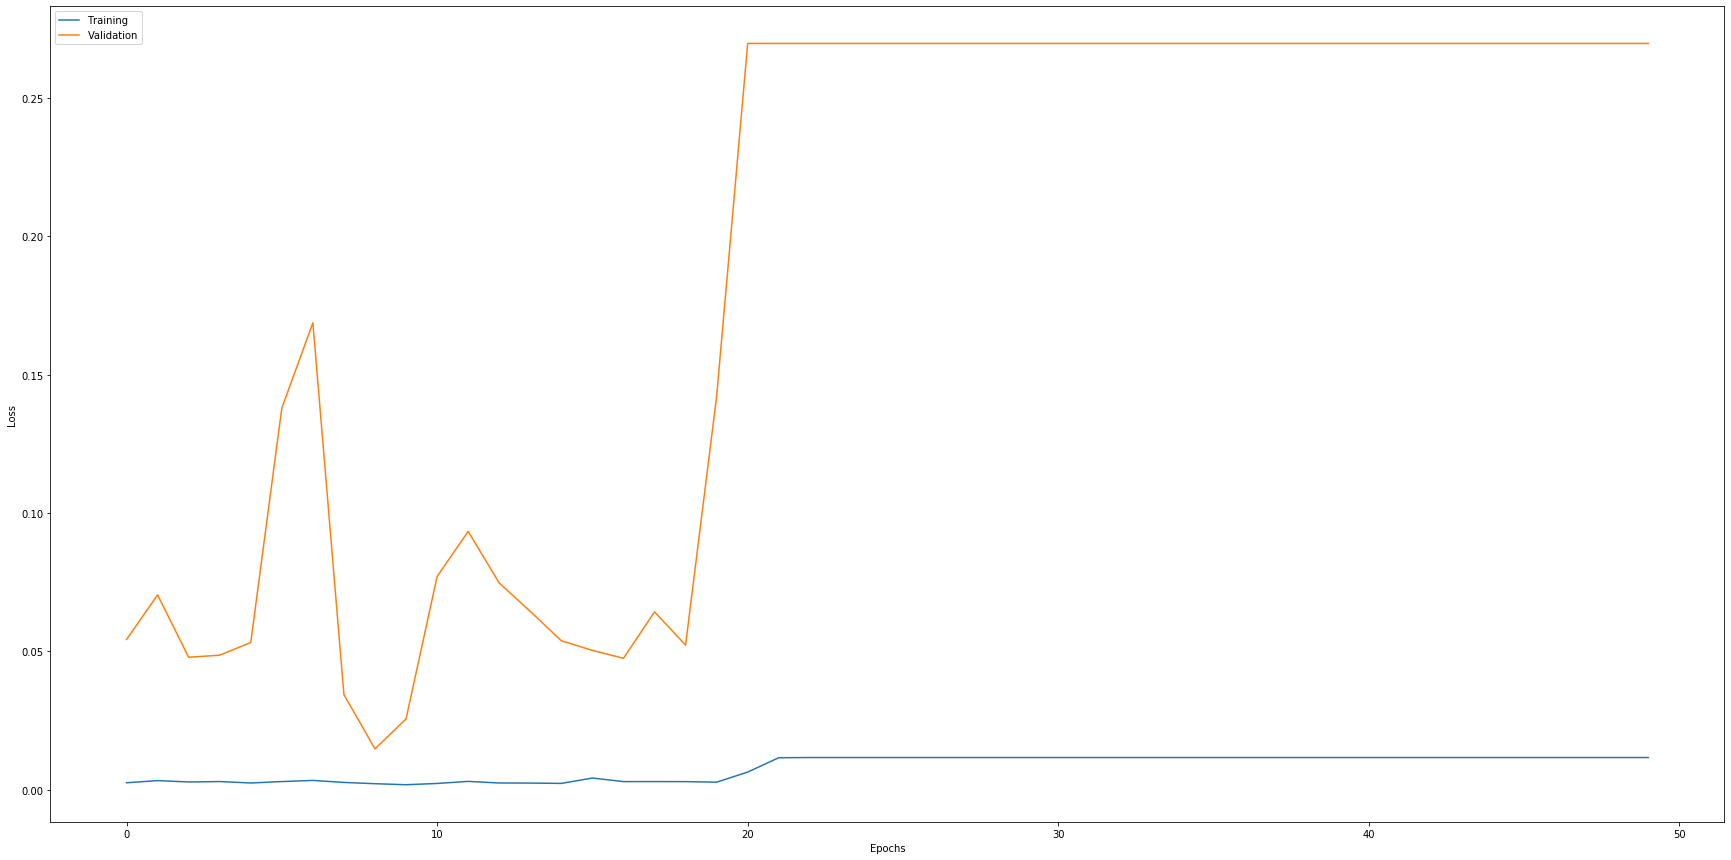

In [21]:
history = regressor.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_valid, y_valid),
                        verbose=2, shuffle=False)
# plot history

plt.figure(figsize=(30, 15))
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# Transform back and plot
y_train_origin = y[:train_size-46]
y_valid_origin = y[train_size:train_size+valid_size]

y_train_pred = regressor.predict(X_train)
y_train_pred_origin = sc_y.inverse_transform(y_train_pred)

y_valid_pred = regressor.predict(X_valid)
y_valid_pred_origin = sc_y.inverse_transform(y_valid_pred)

_y_train_pred_origin = y_train_pred_origin[:, 0:1]
_y_valid_pred_origin = y_valid_pred_origin[:, 0:1]




/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


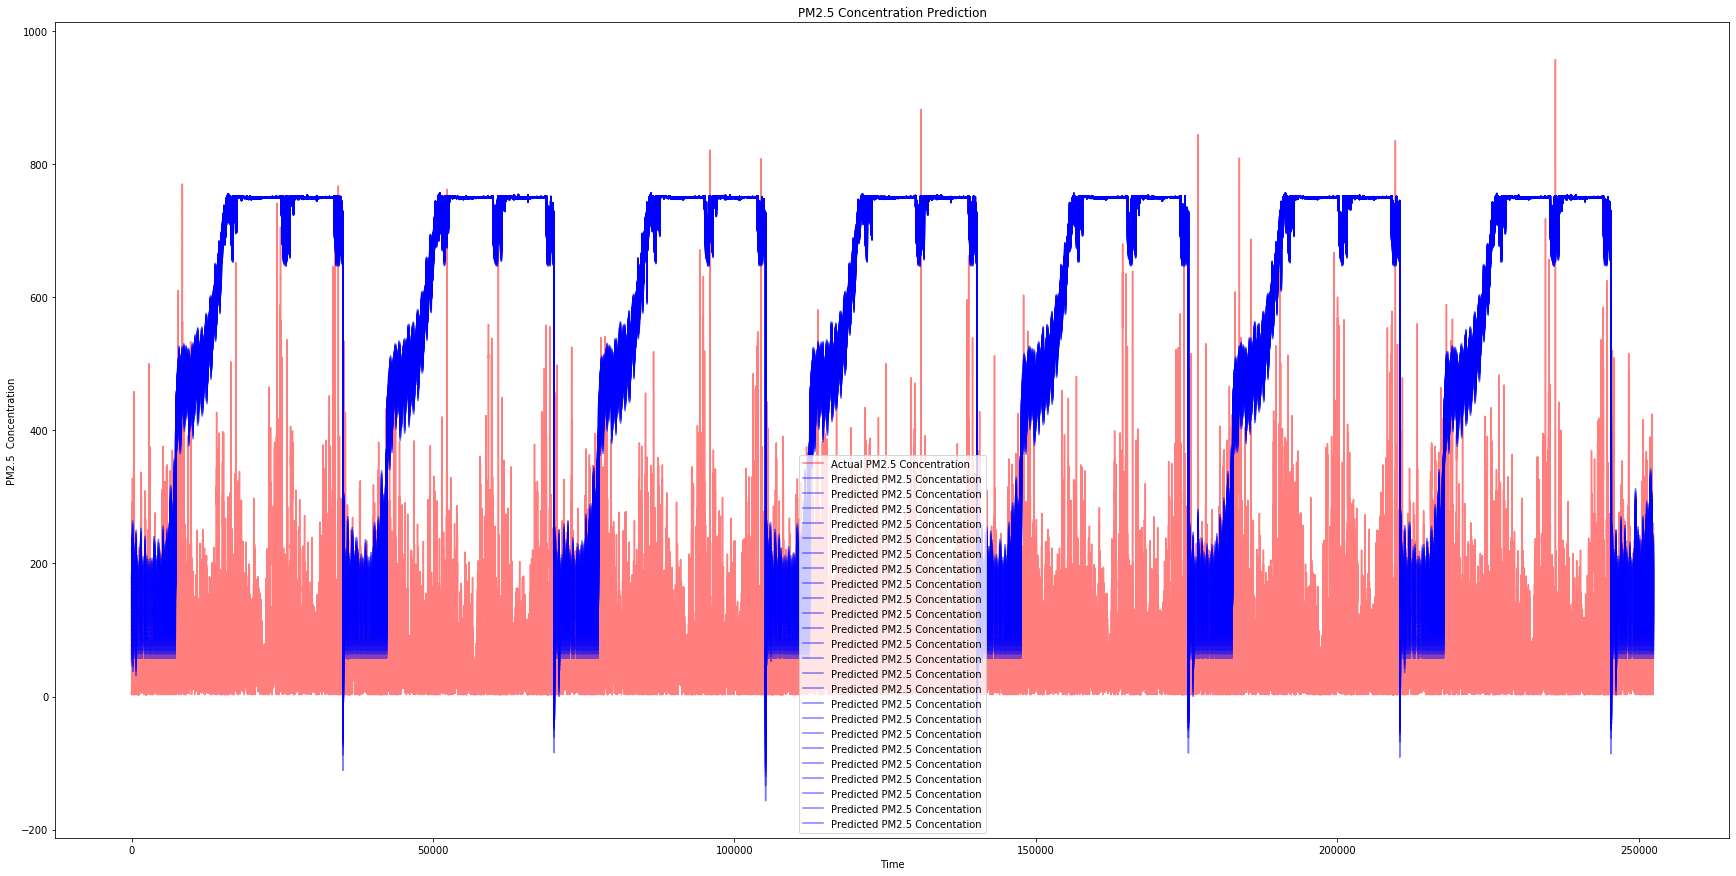

In [18]:
plot_predictions(y_train_origin, y_train_pred_origin)


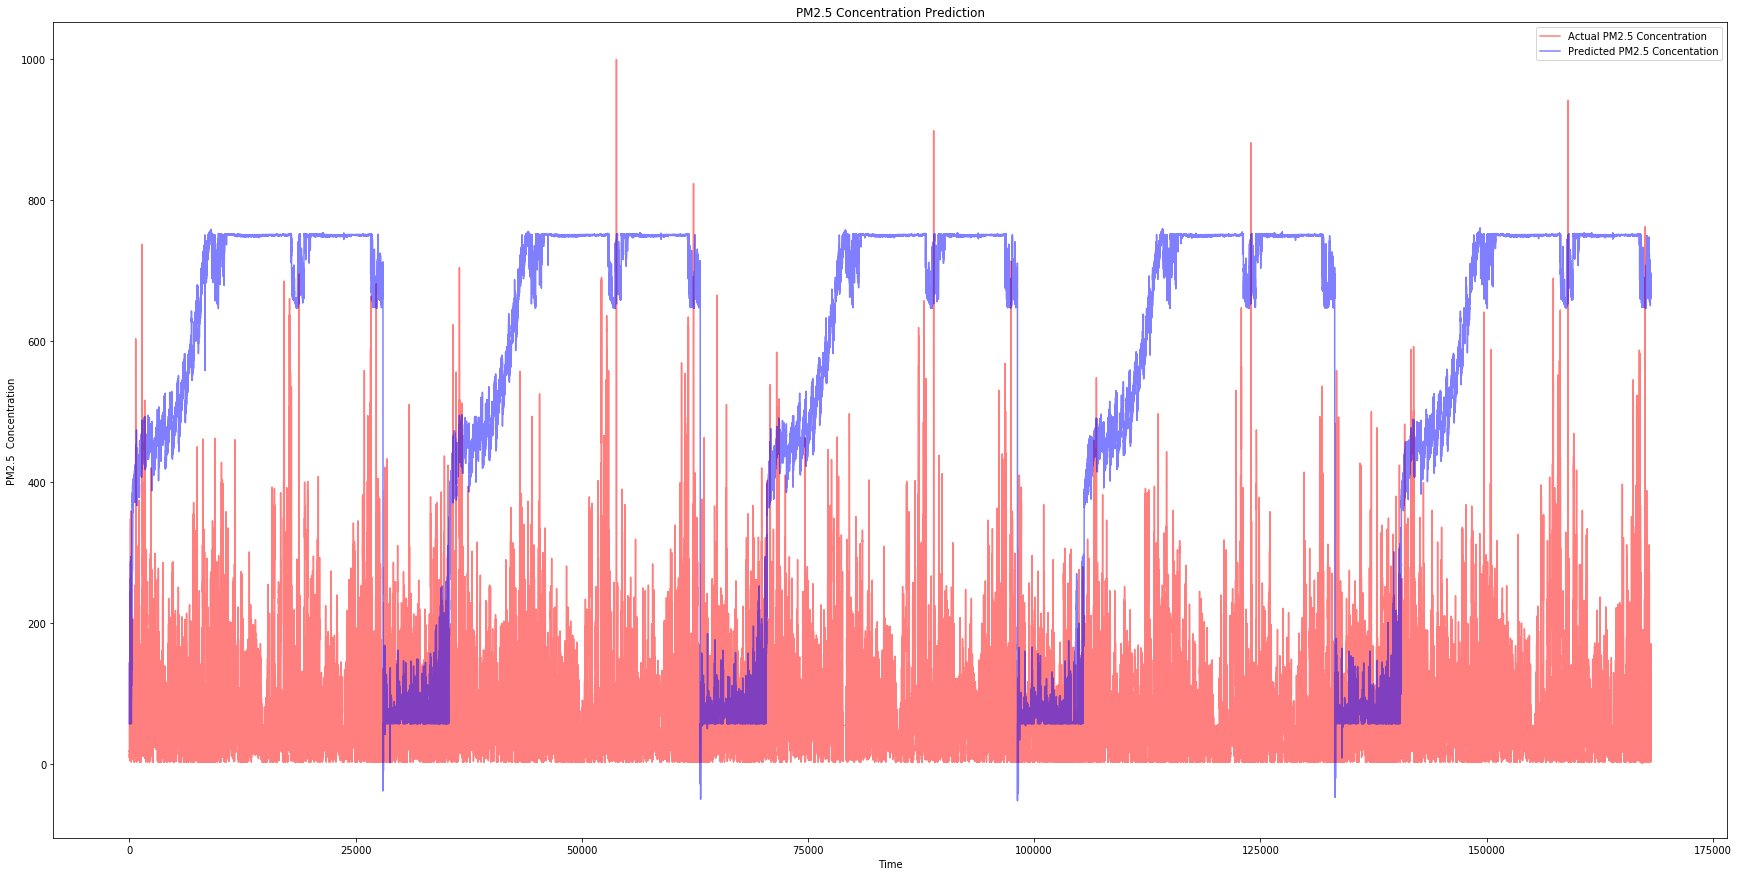

In [19]:
plot_predictions(y_valid_origin, y_valid_pred_origin[:,0:1])
